In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ, transpile, assemble
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

aer_sim = Aer.get_backend('aer_simulator')

error_meas_free  = pauli_error([('I', 1)])
noise_model_free = NoiseModel()
noise_model_free.add_all_qubit_quantum_error(error_meas_free, "measure")

eps = 0.04
error_meas  = pauli_error([('X', eps), ('Z', eps), ('I', 1 - 2 * eps)])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_meas, "measure")

In [2]:
def comp_error_rate(b1, s1, b2, s2):
    n = 0
    d = 0
    for idx in range(len(b1)):
        if (b1[idx] == b2[idx]):
            n = n + 1
            if (s1[idx] != s2[idx]):
                d = d + 1
    return d / n

In [3]:
# Basis: 0 for X
#        1 for Z
# State: 0 for |0> or |+>
#        1 for |1> or |->

def bb84(n, noise_model):    
    # Alice generate x, sa
    x  = randint(2, size = n)
    sa = randint(2, size = n)

    # Bob generate y
    y  = randint(2, size = n)
    sb = np.array([0] * n)

    key = []

    # Exchange 
    for idx in range(n):
        # Alice init the basis
        circ = QuantumCircuit(1, 1)
        if   x[idx] == 0 and sa[idx] == 0:  # |+>
                circ.h(0)
        elif x[idx] == 0 and sa[idx] == 1:  # |->
                circ.x(0)
                circ.h(0)
        elif x[idx] == 1 and sa[idx] == 0:  # |0>
                pass
        elif x[idx] == 1 and sa[idx] == 1:  # |1>
                circ.x(0)

        circ.barrier(0)

        # Bob measurement
        if y[idx] == 0:
            circ.h(0)
        circ.measure(0, 0)

        #print(x[idx], sa[idx])
        #print(circ) #.draw(output = 'mpl')

        # Simulateion
        t_circ = transpile(circ, aer_sim)
        qobj   = assemble(t_circ)
        job    = aer_sim.run(qobj, noise_model = noise_model, shots = 1, memory=True)
        res    = job.result().get_memory(circ)[0]
        
        sb[idx] = 0 if (res == '0') else 1

    rate_b = comp_error_rate(x, sa, y, sb)
    
    for idx in range(n):
        if (x[idx] == y[idx]):
            key = key + [sa[idx]]
    
    return (x, sa, y, sb, rate_b, key)

In [4]:
def bb84_eve(n, noise_model):    
    # Alice generate x, sa
    x  = randint(2, size = n)
    sa = randint(2, size = n)

    # Eva generate z
    z  = randint(2, size = n)
    sz = np.array([0] * n)
    
    # Bob generate y
    y  = randint(2, size = n)
    sb = np.array([0] * n)

    key = []

    # Exchange 
    for idx in range(n):
        # Alice init the basis
        circ = QuantumCircuit(1, 2)
        if   x[idx] == 0 and sa[idx] == 0:  # |+>
                circ.h(0)
        elif x[idx] == 0 and sa[idx] == 1:  # |->
                circ.x(0)
                circ.h(0)
        elif x[idx] == 1 and sa[idx] == 0:  # |0>
                pass
        elif x[idx] == 1 and sa[idx] == 1:  # |1>
                circ.x(0)

        circ.barrier(0)

        # Eva measurement and set qubit to the corresponding basis
        if z[idx] == 0:
            circ.h(0)
        circ.measure(0, 1)
        if z[idx] == 0:
            circ.h(0)

        circ.barrier(0)
        
        # Bob measurement
        if y[idx] == 0:
            circ.h(0)
        circ.measure(0, 0)

        #print(x[idx], sa[idx])
        #print(circ) #.draw(output = 'mpl')

        # Simulateion
        t_circ = transpile(circ, aer_sim)
        qobj   = assemble(t_circ)
        job    = aer_sim.run(qobj, noise_model = noise_model, shots = 1, memory = True)
        res    = job.result().get_memory(circ)[0]
        
        sb[idx] = 0 if (res[1] == '0') else 1
        sz[idx] = 0 if (res[0] == '0') else 1
        
    rate_b = comp_error_rate(x, sa, y, sb)
    rate_e = comp_error_rate(x, sa, z, sz)
    
    for idx in range(n):
        if (x[idx] == y[idx]):
            key = key + [sa[idx]]
    
    return (x, sa, y, sb, rate_b, z, sz, rate_e, key)

# EAP A

In [5]:
n = 40
(x, sa, y, sb, rate_b, key) = bb84(40, noise_model_free)
print(f"error rate = {rate_b}")
print(f"key        = {key}")
print("  x| sa|  y| sb")
print("---------------")
for idx in range(n):
    print(f"  {x[idx]}|  {sa[idx]}|  {y[idx]}|  {sb[idx]}")

/home/xuan/.local/lib/python3.9/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


error rate = 0.0
key        = [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
  x| sa|  y| sb
---------------
  0|  0|  0|  0
  1|  1|  0|  1
  0|  0|  1|  1
  0|  1|  0|  1
  0|  0|  0|  0
  1|  0|  1|  0
  1|  1|  1|  1
  1|  0|  1|  0
  0|  0|  1|  1
  1|  0|  1|  0
  0|  1|  0|  1
  1|  0|  0|  1
  0|  1|  1|  0
  1|  1|  1|  1
  0|  1|  0|  1
  1|  0|  0|  1
  0|  0|  1|  1
  1|  0|  1|  0
  0|  1|  0|  1
  1|  0|  0|  0
  1|  1|  0|  1
  0|  1|  1|  0
  1|  1|  1|  1
  0|  1|  1|  1
  1|  1|  1|  1
  0|  0|  0|  0
  1|  0|  0|  1
  1|  0|  0|  1
  1|  1|  1|  1
  0|  0|  1|  0
  0|  0|  0|  0
  0|  0|  1|  0
  1|  1|  0|  0
  0|  1|  0|  1
  0|  1|  0|  1
  0|  0|  0|  0
  0|  1|  1|  1
  0|  0|  1|  0
  0|  0|  1|  1
  1|  0|  0|  1


# EXP B

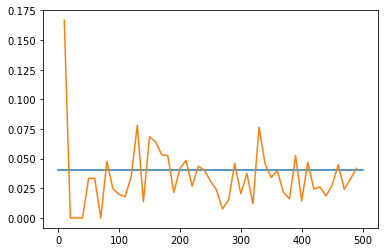

In [6]:
rate_b = []
for n in range(10, 500, 10):
    _, _, _, _, tmp, _ = bb84(n, noise_model)
    rate_b += [tmp]
plt.plot([0, 500], [0.04, 0.04])
plt.plot(range(10, 500, 10), rate_b)
plt.show()

# EXP C

In [7]:
n = 40
(x, sa, y, sb, rate_b, z, sz, rate_e, key) = bb84_eve(40, noise_model_free)
print(f"Bob's error rate = {rate_b}")
print(f"Eve's error rate = {rate_e}")
print(f"key              = {key}")
print("  x| sa|  y| sb|  z| sz")
print("-----------------------")
for idx in range(n):
    print(f"  {x[idx]}|  {sa[idx]}|  {y[idx]}|  {sb[idx]}|  {z[idx]}|  {sz[idx]}")

Bob's error rate = 0.2222222222222222
Eve's error rate = 0.0
key              = [0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
  x| sa|  y| sb|  z| sz
-----------------------
  0|  1|  1|  0|  0|  1
  1|  0|  1|  1|  0|  0
  0|  0|  1|  1|  0|  0
  0|  1|  0|  1|  0|  1
  1|  0|  1|  0|  1|  0
  1|  1|  1|  1|  1|  1
  1|  1|  1|  1|  0|  1
  1|  1|  0|  1|  1|  1
  0|  0|  1|  0|  0|  0
  1|  0|  1|  0|  0|  1
  0|  1|  1|  0|  1|  0
  1|  0|  1|  0|  1|  0
  1|  1|  0|  1|  0|  1
  1|  1|  0|  0|  0|  0
  1|  0|  0|  1|  0|  1
  1|  1|  0|  1|  0|  1
  1|  1|  0|  1|  1|  1
  0|  0|  1|  1|  0|  0
  1|  1|  1|  1|  1|  1
  0|  1|  0|  0|  1|  0
  0|  1|  0|  1|  1|  0
  1|  1|  1|  1|  1|  1
  0|  0|  0|  0|  0|  0
  0|  1|  0|  0|  1|  0
  1|  1|  1|  1|  1|  1
  0|  0|  0|  0|  0|  0
  0|  1|  0|  1|  0|  1
  1|  0|  1|  0|  1|  0
  0|  1|  0|  0|  1|  1
  1|  1|  1|  0|  0|  1
  1|  1|  1|  1|  1|  1
  0|  0|  0|  0|  0|  0
  1|  1|  1|  1|  1|  

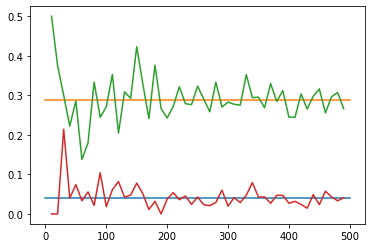

In [8]:
rate_b = []
rate_e = []
for n in range(10, 500, 10):
    _, _, _, _, tmp1, _, _, tmp2, _ = bb84_eve(n, noise_model)
    rate_b += [tmp1]
    rate_e += [tmp2]
plt.plot([0, 500], [0.04, 0.04])
plt.plot([0, 500], [0.2884, 0.2884])
plt.plot(range(10, 500, 10), rate_b)
plt.plot(range(10, 500, 10), rate_e)
plt.show()